## Time-Series Analysis of:

### 1. Delhi Climate Forecasting based on data from 2013 - 2017
### 2. Alcohol Consumption

#### Importing Libraries

In [1]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

import numpy as np

from pmdarima.arima import auto_arima

import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'text.color' : "black",
                     'axes.labelcolor' : "black"})
plt.style.use('seaborn-darkgrid')

### Delhi Climate Forecasting based on data from 2013 - 2017

#### EDA

In [2]:
# Read the csv file
climate = pd.read_csv('data/DailyDelhiClimateTrain.csv', parse_dates=True, index_col='date')

In [3]:
climate.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


In [4]:
climate.tail()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2016-12-28,17.217391,68.043478,3.547826,1015.565217
2016-12-29,15.238095,87.857143,6.000000,1016.904762
2016-12-30,14.095238,89.666667,6.266667,1017.904762
2016-12-31,15.052632,87.000000,7.325000,1016.100000
2017-01-01,10.000000,100.000000,0.000000,1016.000000


For the month 2017-01 only one day data is present. It is better to remove this row as it will fail to generalize the complete month.

In [5]:
# check for any null values
climate.isnull().sum()

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [6]:
# resample the data by month start with mean calculation and deleting the last reading from dataset.
climate=climate.resample('MS').mean().dropna().iloc[:-1, :]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001946B4D5E88>,
      dtype=object)

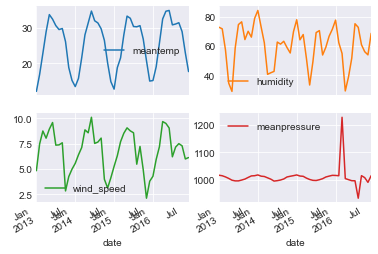

In [7]:
# subplots
climate.plot(subplots=True, layout=(2,2))

##### I will analyze and forecast monthly meantemp. It is easy to see that there is a presence of seasonal component.

#### Time Series Analysis on 'meantemp'

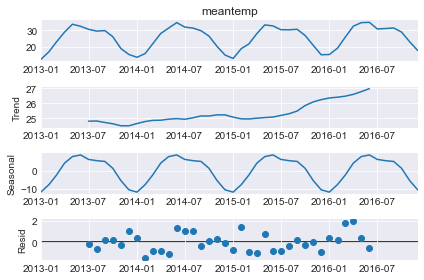

In [8]:
# performing the seasonal decompose to see the presence of trend, seasonality
seasonal = seasonal_decompose(climate['meantemp'].dropna())
seasonal.plot();

In [9]:
# perform Augmented Dickey Fuller Test to check for data-Stationarity
stationarity_result = adfuller(climate['meantemp'])
stationarity_result[1]

# The result of 0.9769699297633487 shows that the data is not stationary

0.9769699297633487

Probabilty that dataset is not stationary: 0.03075728778782369%. If the probabilty < 5%. The dataset is stationary


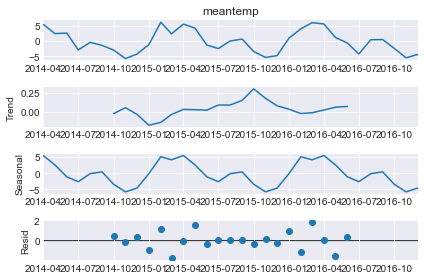

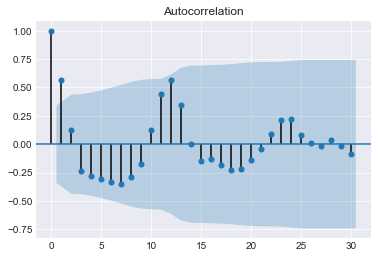

In [10]:
# seasonal pattern period

# we detrend / smooth the dataset with a rolling mean greater than seasonal period. Since this is weather dataset. The seasonal
# period should be 12 months. Let's check with the rolling mean
meantemp = climate['meantemp'] - climate['meantemp'].rolling(15).mean()
meantemp = meantemp.diff(1).dropna() # perform to make dataset stationary

# check if dataset is stationary
print('Probabilty that dataset is not stationary: {}%. If the probabilty < 5%. The dataset is stationary'.format(adfuller(meantemp)[1]*100))

# check if trend is centered around 0.
seasonal = seasonal_decompose(meantemp)
seasonal.plot();
plt.show()

# autocorrelation helps in determing if seasonality is present in the dataset
plot_acf(meantemp, lags = 30);


##### From above charts, the seasonality of 12 months is confirmed.

#### Find SARIMAX model

Probabilty that dataset is not stationary: 0.08355617849947802%. If the probabilty < 5%. The dataset is stationary


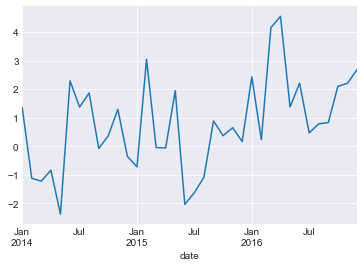

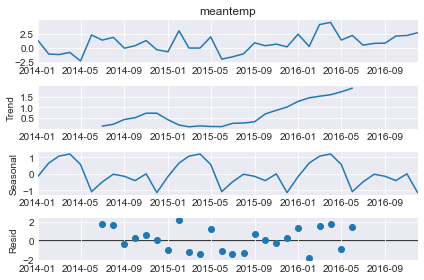

In [11]:
# Since there is a strong presence of seasonality. Perform the seasonality difference
meantemp = climate['meantemp'].diff(12).dropna()

# check if dataset is stationary
print('Probabilty that dataset is not stationary: {}%. If the probabilty < 5%. The dataset is stationary'.format(adfuller(meantemp)[1]*100))

# plotting the dataset
meantemp.plot()

decompose = seasonal_decompose(meantemp)
decompose.plot();

###### The dataset is now stationary and the mean of dataset is not centered around 0.

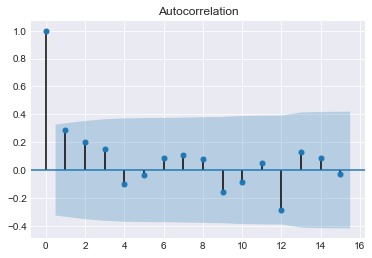

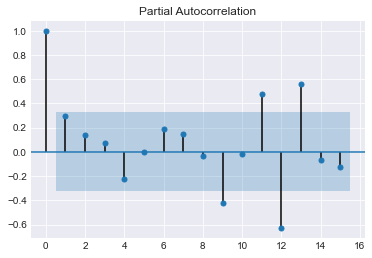

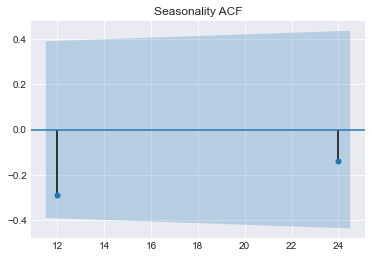

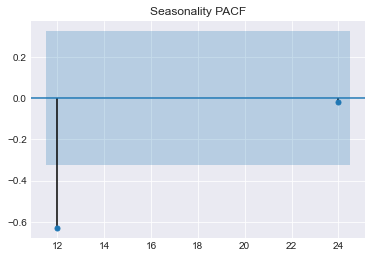

In [12]:
# plotting acf and pacf to obtain (p, q)
plot_acf(meantemp, lags=15);
plot_pacf(meantemp,lags=15);

# plotting acf and pacf at lags 12 and 24 to obtain (P, Q)
# the dataset is not sufficient to generate plot for more lags 
# it is difficult to find (P, Q)
lags = [12,24]
plot_acf(meantemp.dropna(), lags=lags, title='Seasonality ACF');

plot_pacf(meantemp.dropna(), lags=lags, title='Seasonality PACF');

##### From above charts, SARIMAX((1,0,0), (1,1,0,12)) model might be a good model. As there we see in seasonality PACF chart we get siginficant dependcy on lag 1 of seasonality 12.

In [13]:
# build the model
model = SARIMAX(climate['meantemp'], order=(1,0,0), seasonal_order=(1,1,0,12),trend='c') # trend = 'c' is due to as our mean of data was not centered around 0

# fit the model
results = model.fit()

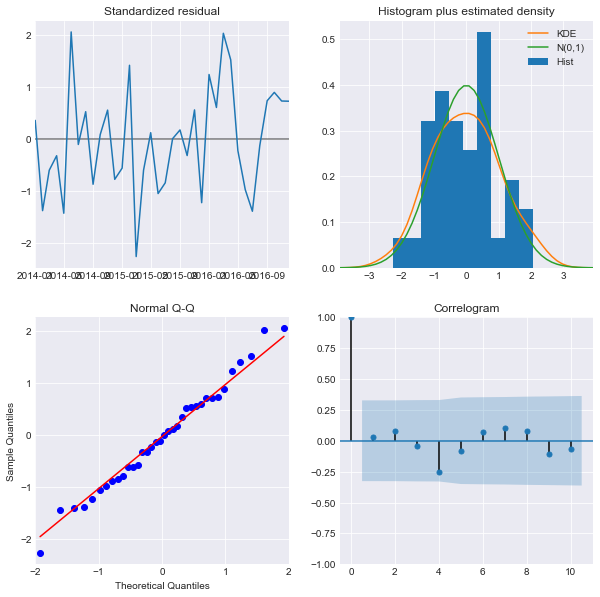

In [14]:
# perform the diagnositcs to check for the quality of model.
results.plot_diagnostics(figsize=(10,10));

##### There is no obvious trend in Standarized residual. The Normal Q-Q shows that noise is not completely normally distributed.

In [15]:
# more details about the model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           meantemp   No. Observations:                   48
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood                 -60.305
Date:                            Mon, 26 Oct 2020   AIC                            128.611
Time:                                    01:45:28   BIC                            134.945
Sample:                                01-01-2013   HQIC                           130.821
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5421      0.310      1.747      0.081      -0.066       1.150
ar.L1          0.5335      0.141      3.783      0.000       0.257       0.810
ar.S.L12      -0.6729      0.151     -4.468      0.000      -0.968      -0.378
sigma2         1.3528      0.421      3.212      0.001       0.527       2.178
===================================================================================
Ljung-Box (Q):                       25.50   Jarque-Bera (JB):                 0.34
Prob(Q):                              0.88   Prob(JB):                         0.84
Heteroskedasticity (H):               1.28   Skew:                             0.11
Prob(H) (two-sided):                  0.68   Kurtosis:                         2.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### According to above summary, model forecast has significant dependency of AR lag1, AR Seasonality L2. Prob(Q) > 5% and Prob(JB) > 5% which shows the residuals are normal and uncorrelated, which is considered a good fit.

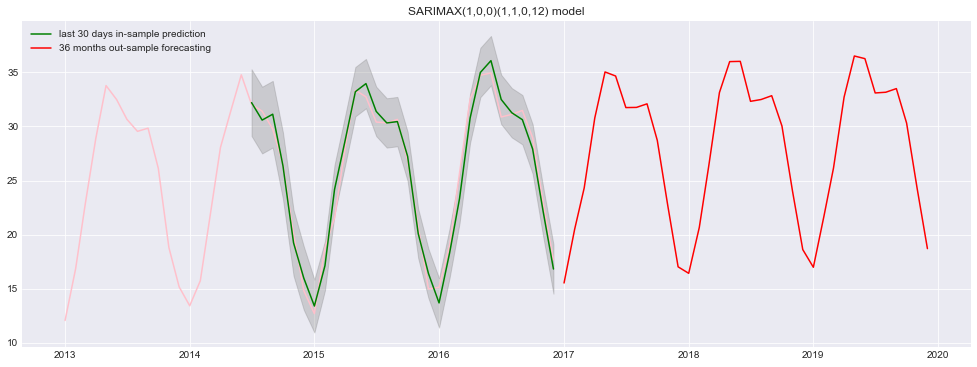

In [16]:
plt.style.use('seaborn-darkgrid')
# plotting the prediction of SARIMAX((1,0,0)(1,1,0,12))
# predicting the last 30 days (one day prediction) of the dataset
predicted = results.get_prediction(-30)
predicted_mean = predicted.predicted_mean # predicted values
predicted_conf_int = predicted.conf_int() # confidence interval


# forecasting next 3 years result
forecasting = results.get_forecast(36)

# plotting
plt.figure(figsize=(17,6))
plt.plot(climate.index,climate['meantemp'], color='pink')

plt.plot(predicted_mean.index, predicted_mean, color='green' ,label='last 30 days in-sample prediction')
plt.fill_between(predicted_mean.index, predicted_conf_int['lower meantemp'], predicted_conf_int['upper meantemp'], color='gray', alpha=0.3)

plt.plot(forecasting.predicted_mean.index, forecasting.predicted_mean, color='red', label='36 months out-sample forecasting')

plt.legend()
plt.title('SARIMAX(1,0,0)(1,1,0,12) model')
plt.show()

### auto_arima to find and fit the best model

In [17]:
# auto_arima to output best model
result = auto_arima(climate['meantemp'].dropna(),
                      seasonal=True, m=12, 
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=140.367, Time=0.11 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=128.611, Time=0.13 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=145.970, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=139.223, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=126.061, Time=0.53 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=128.003, Time=1.72 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=129.533, Time=0.26 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=128.057, Time=0.40 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=128.059, Time=0.46 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=127.619, Time=0.31 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=inf, Time=1.85 sec
 ARIMA(1,0,0)(2,1,0)[12]             : AIC=131.87

In [18]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood                 -58.030
Date:                            Mon, 26 Oct 2020   AIC                            126.061
Time:                                    01:45:36   BIC                            133.978
Sample:                                         0   HQIC                           128.824
                                             - 48                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0621      0.400      2.658      0.008       0.279       1.845
ar.L1          0.4361      0.161      2.702      0.007       0.120       0.752
ar.S.L12      -1.0160      0.209     -4.854      0.000      -1.426      -0.606
ar.S.L24      -0.6040      0.204     -2.956      0.003      -1.004      -0.203
sigma2         0.9109      0.320      2.844      0.004       0.283       1.539
===================================================================================
Ljung-Box (Q):                       32.83   Jarque-Bera (JB):                 0.43
Prob(Q):                              0.57   Prob(JB):                         0.80
Heteroskedasticity (H):               1.32   Skew:                             0.01
Prob(H) (two-sided):                  0.64   Kurtosis:                         2.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### The dataset shows significant dependency on AR lag 1, AR seasonality lag 1 and 2. Also Prob(Q) and Prob(JB) shows that residuals are normal and uncorrelated

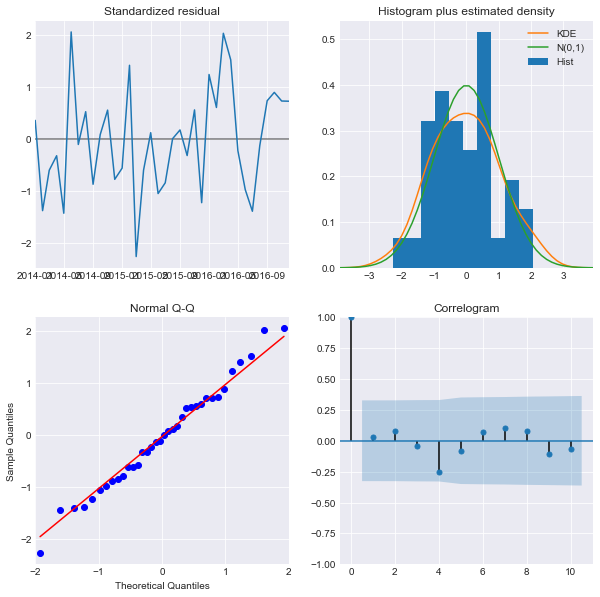

In [19]:
# fitting the auto_arima defined model
# building the model
model = SARIMAX(climate['meantemp'], order=(1,0,0), seasonal_order=(1,1,0,12),trend='c')

# fit the model
results = model.fit()
results.plot_diagnostics(figsize=(10,10));

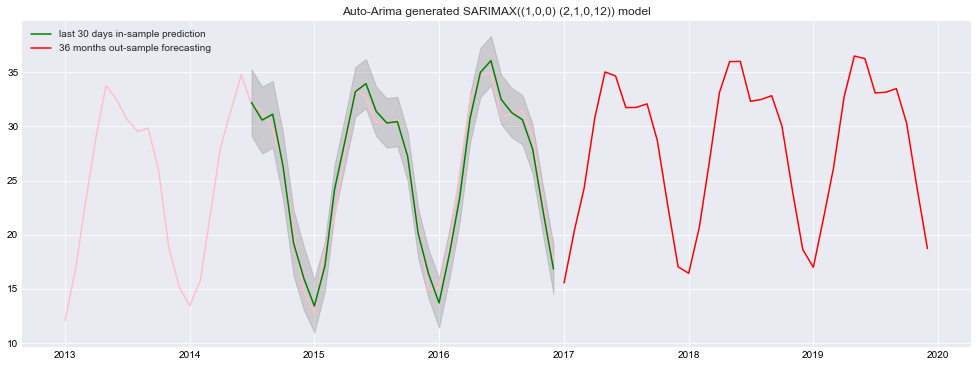

In [20]:

# plotting the prediction of SARIMAX((1,0,0)(2,1,0,12))
# predicting the last 30 days in-sample (one day prediction) of the dataset
predicted = results.get_prediction(-30)
predicted_mean = predicted.predicted_mean # predicted values
predicted_conf_int = predicted.conf_int() # confidence interval


# forecasting next 3 years result
forecasting = results.get_forecast(36)

# plotting
plt.figure(figsize=(17,6))
plt.plot(climate.index,climate['meantemp'], color='pink')
plt.plot(predicted_mean.index, predicted_mean, color='green' ,label='last 30 days in-sample prediction')
plt.plot(forecasting.predicted_mean.index, forecasting.predicted_mean, color='red', label='36 months out-sample forecasting')
plt.fill_between(predicted_mean.index, predicted_conf_int['lower meantemp'], predicted_conf_int['upper meantemp'], color='gray', alpha=0.3)
plt.legend()
plt.title('Auto-Arima generated SARIMAX((1,0,0) (2,1,0,12)) model')
plt.xticks(color='black')
plt.yticks(color='black')
plt.show()




##  Alcohol Consumption Prediction and Forecasting

#### EDA

In [21]:
# read csv
alcohol = pd.read_csv('data/Alcohol_Sales.csv', parse_dates=True, index_col='DATE')

# modify the column name
alcohol.columns = ['consumption']
alcohol.head()

,consumption
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [22]:
# check for null values and data type of columns
alcohol.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 325 entries, 1992-01-01 to 2019-01-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   consumption  325 non-null    int64
dtypes: int64(1)
memory usage: 5.1 KB


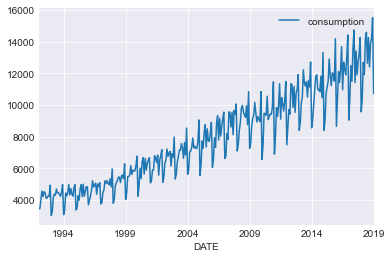

In [23]:
# plot the data
alcohol.plot()

##### from above data we see that it is trend*multiplicative. Thus we take the log of data before performing any other operation

<Figure size 2160x720 with 0 Axes>

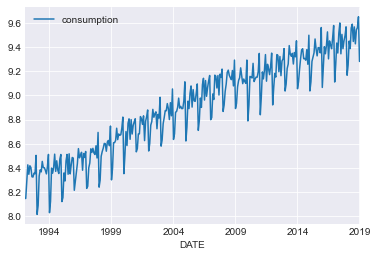

In [24]:
# tranforming the data by taking log of data
alcohol = alcohol.apply(np.log)
plt.figure(figsize=(30,10))
alcohol.plot()
plt.show()

#### Time Series Analysis to find the SARIMAX model

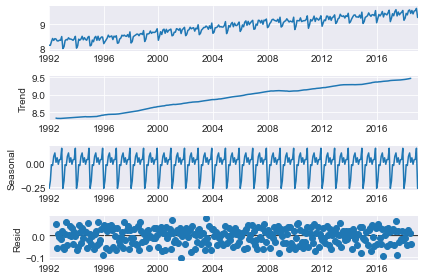

In [25]:
# seasonal decompose
seasonal = seasonal_decompose(alcohol, freq=12)
seasonal.plot();

##### From above trend chart, there is a upward trend in the data and the presence of seasonality.

In [26]:
# check for stationarity of data
stationarity_res = adfuller(alcohol)
# check if dataset is stationary
print('Probabilty that dataset is not stationary: {}%. If the probabilty < 5%. The dataset is stationary'.format(stationarity_res[1]*100))


Probabilty that dataset is not stationary: 87.08739413383287%. If the probabilty < 5%. The dataset is stationary


Probabilty that dataset is not stationary: 0.08417111196670436%. If the probabilty < 5%. The dataset is stationary


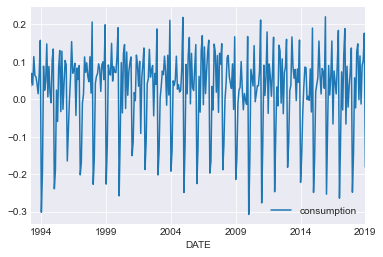

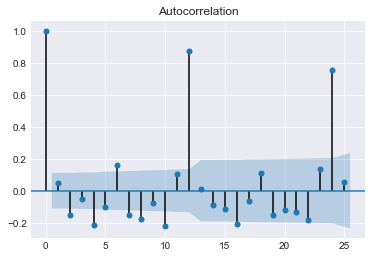

In [27]:
# detrend the data to find the seasonality period.
detrend = alcohol - alcohol.rolling(15).mean()
detrend.dropna(inplace=True)
# check if dataset is stationary
print('Probabilty that dataset is not stationary: {}%. If the probabilty < 5%. The dataset is stationary'.format(adfuller(detrend)[1]*100))

detrend.plot()

# plot_acf to check for seasonality
plot_acf(detrend);

##### From above acf plot, there is a presence of seasonality period of 12 months.

Probabilty that dataset is not stationary: 8.240865686942816e-10%. If the probabilty < 5%. The dataset is stationary


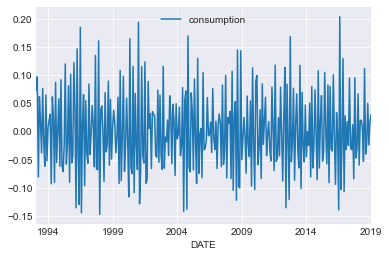

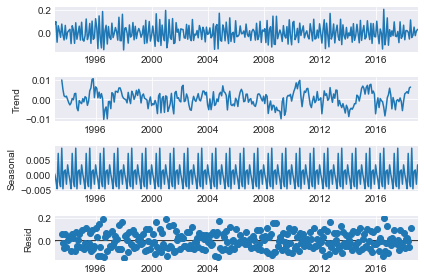

In [28]:
# performing first order diff and seasonal 12 order difference to make the dataset stationary. As there is presence
# of strong trend evidence and seasonlity.
alcohol_stationary = alcohol.diff(1).diff(12).dropna()

# check if dataset is stationary
print('Probabilty that dataset is not stationary: {}%. If the probabilty < 5%. The dataset is stationary'.format(adfuller(alcohol_stationary)[1]*100))

alcohol_stationary.plot()

# perform seasonal decompose
seasonal = seasonal_decompose(alcohol_stationary, period=12)
seasonal.plot();

#### From above results:
###### 1. Data is now stationary
###### 2. Trend seasonal decompose mean is centered around 0.

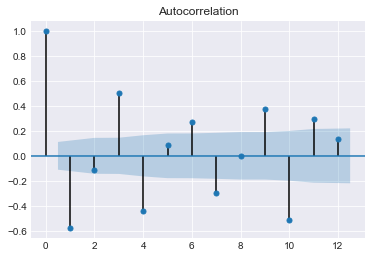

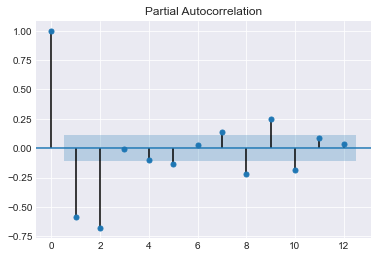

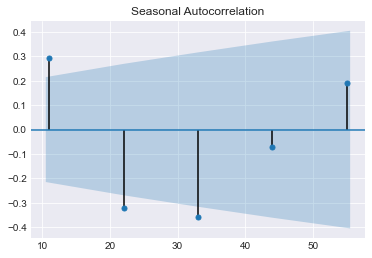

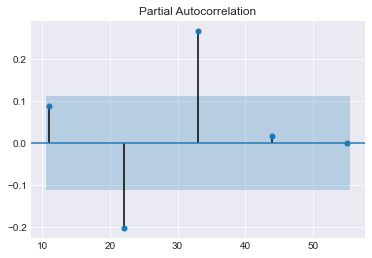

In [29]:
# plto acf and pacf for p,q
plot_acf(alcohol_stationary, lags=12);
plot_pacf(alcohol_stationary, lags=12);

# plot seasonal acf and pacf for P, Q
lags = [11,22,33,44,55]
plot_acf(alcohol_stationary, lags=lags, title = 'Seasonal Autocorrelation');
plot_pacf(alcohol_stationary, lags=lags, title = 'Partial Autocorrelation');


#### From above plots we can initially try with SARIMAX((2,1,0), (3,1,2, 12)) model. As for p, q ACF tapers off while there is a strong cut off after lag 2. For P, Q (seasonality)  There is a strong cut off after lag 3 for AR.S and strong cut off after lag 2 for MA.S

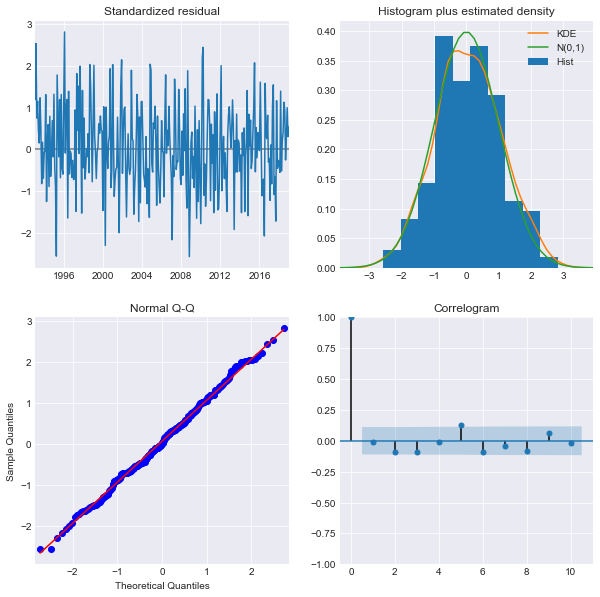

In [30]:
# fit SARIMAX((2, 1, 0), (3, 1, 2, 12) )model
model = SARIMAX(alcohol, order=(2, 1, 0), seasonal_order=(3, 1, 2, 12))
result = model.fit()
result.plot_diagnostics(figsize=(10, 10));

##### From above diagnostic, standardized residual looks like a random noise. Normal Q-Q plot determines that noise is normally distributed. Correlogram plot is below the confidence interval. Overall it determines that the fit SARIMAX model is a good choice for prediction. Let's look at the summary of the model

In [31]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                             consumption   No. Observations:                  325
Model:             SARIMAX(2, 1, 0)x(3, 1, [1, 2], 12)   Log Likelihood                 615.578
Date:                                 Mon, 26 Oct 2020   AIC                          -1215.157
Time:                                         01:45:52   BIC                          -1185.213
Sample:                                     01-01-1992   HQIC                         -1203.189
                                          - 01-01-2019                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7727      0.050    -15.367      0.000      -0.871      -0.674
ar.L2         -0.5349      0.046    -11.614      0.000      -0.625      -0.445
ar.S.L12       0.3569      0.128      2.786      0.005       0.106       0.608
ar.S.L24      -0.4117      0.075     -5.480      0.000      -0.559      -0.264
ar.S.L36      -0.3992      0.084     -4.734      0.000      -0.564      -0.234
ma.S.L12      -0.9388      0.141     -6.671      0.000      -1.215      -0.663
ma.S.L24       0.3041      0.122      2.496      0.013       0.065       0.543
sigma2         0.0010   9.65e-05     10.654      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                       61.14   Jarque-Bera (JB):                 0.95
Prob(Q):                              0.02   Prob(JB):                         0.62
Heteroskedasticity (H):               0.75   Skew:                             0.06
Prob(H) (two-sided):                  0.14   Kurtosis:                         2.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### P > |z| determines the siginificance of the lag. All above lags are significant in the prediction / forecasting. Prob(JB) > 62% (residuals are uncorrelated). This model can be used for the prediction / forecasting.

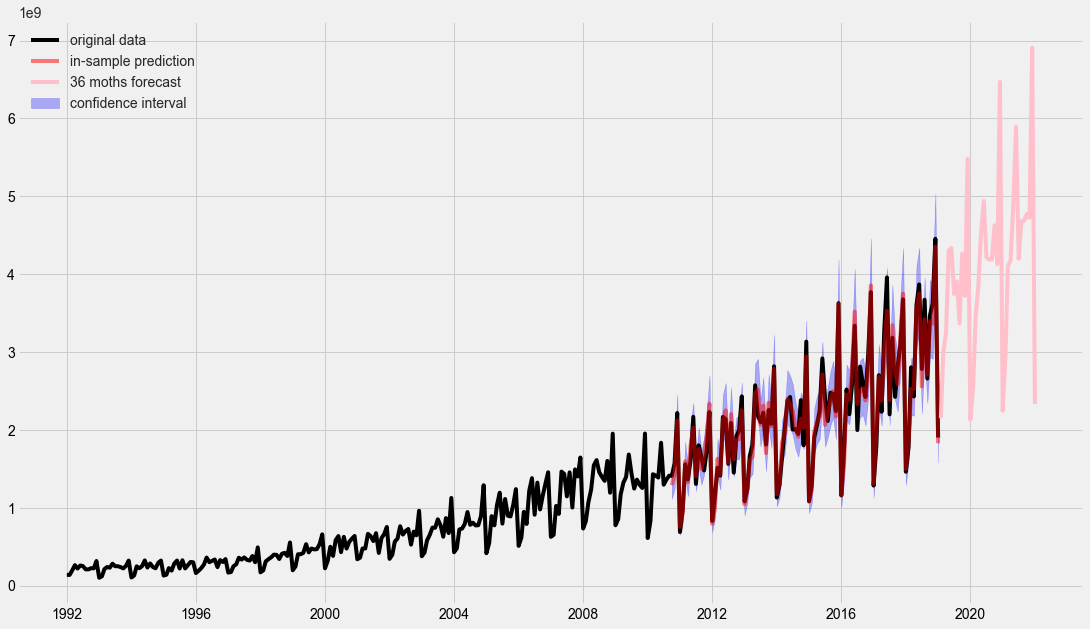

In [32]:
plt.style.use('fivethirtyeight')
ax = plt.figure(figsize=(17,10))
# plot dataset
plt.plot(alcohol.index, 10**alcohol,c='black', label='original data')

# plot the prediction of last 100 in-sample
predict = result.get_prediction(-100)
predict_mean = predict.predicted_mean
conf_interval = predict.conf_int()
plt.plot(predict_mean.index, 10**predict_mean, c='red', alpha=0.5, label='in-sample prediction')
plt.fill_between(predict_mean.index, 10**conf_interval['lower consumption'], 10**conf_interval['upper consumption'], color='blue', alpha=0.3, label='confidence interval')

#plot forecasting of next 36 months
forecast = result.get_forecast(36)
forecast_mean = forecast.predicted_mean
plt.plot(forecast_mean.index, 10**forecast_mean, c='pink', label='36 moths forecast')

plt.legend()
plt.xticks(color='black')
plt.yticks(color='black')
plt.show()

#### Determine the optimal model using auto_arima and compare with above selected model

In [33]:
result_auto_arima = auto_arima(alcohol, seasonal=True,d=1, D=1, m=12,trace=True,
                      error_action='ignore',
                      suppress_warnings=True )


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=3.93 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-747.040, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-872.928, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.68 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-873.295, Time=0.06 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=1.38 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.14 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=-1072.111, Time=0.27 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-1079.441, Time=0.57 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-1100.879, Time=1.83 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=4.99 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.79 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-919.311, Time=1.67 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-1099.554, Time=2.11 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=-1

In [34]:
result_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  325
Model:             SARIMAX(3, 1, 1)x(2, 1, [], 12)   Log Likelihood                 561.154
Date:                             Mon, 26 Oct 2020   AIC                          -1108.308
Time:                                     01:46:54   BIC                          -1082.107
Sample:                                          0   HQIC                         -1097.836
                                             - 325                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2075      0.078     -2.660      0.008      -0.360      -0.055
ar.L2          0.1066      0.094      1.130      0.258      -0.078       0.292
ar.L3          0.5554      0.074      7.548      0.000       0.411       0.700
ma.L1         -0.9233      0.052    -17.866      0.000      -1.025      -0.822
ar.S.L12      -0.2290      0.065     -3.520      0.000      -0.357      -0.101
ar.S.L24      -0.2783      0.060     -4.601      0.000      -0.397      -0.160
sigma2         0.0016      0.000     12.999      0.000       0.001       0.002
===================================================================================
Ljung-Box (Q):                      183.08   Jarque-Bera (JB):                 3.68
Prob(Q):                              0.00   Prob(JB):                         0.16
Heteroskedasticity (H):               0.77   Skew:                            -0.12
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### AR.L2 does not have significant effect on the prediction.

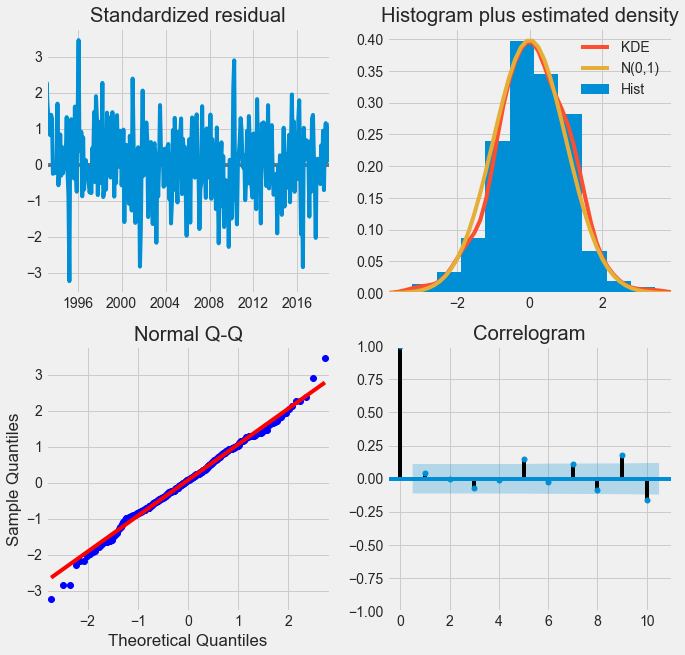

In [35]:
# fit the auto_arima model (3,1,1) (2,1,0, 12) for diagnostic plot()
model = SARIMAX(alcohol, order= (3,1,1), seasonal_order = (2,1,0,12))
result = model.fit()
result.plot_diagnostics(figsize=(10,10));

#### Correlogram plot is not below confidence interval for each lag. Also Normal Q-Q plot shows a little deviation compared to the plot of (2,1,0) (3,1,2,12) model. According to me, (2,1,0) (3,1,2,12) model is a better model than recommended by auto_arima.